# EV Charging Energy Prediction - Machine Learning Models

This notebook implements 4 different models to predict Energy (kWh) consumption:
1. **Linear Regression** - Simple baseline model
2. **Random Forest** - Ensemble tree-based model
3. **XGBoost** - Advanced gradient boosting model
4. **LSTM** - Deep learning model for time series

Target: Predict **Energy (kWh)** based on charging session features


In [17]:
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)


Libraries imported successfully!
TensorFlow version: 2.10.0
Pandas version: 2.3.2


## Step 2: Load and Explore the Preprocessed Data


In [18]:
# Load the preprocessed dataset
df = pd.read_csv('Dataset/EVcharging_preprocessed.csv')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

# Display first few rows
df.head()


Dataset loaded successfully!
Shape: (102781, 71)
Rows: 102,781
Columns: 71


,timestamp,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),...,User Avg Fee,Station Avg Energy,Station Std Energy,Station Popularity,Station Avg Charging Time,Station Avg Fee,Station Unique Users,Hourly Avg Energy,Day of Week Avg Energy,Monthly Avg Energy
0,2018-01-01 10:36:00,PALO ALTO CA / CAMBRIDGE #1,0024:B100:0002:1329,City of Palo Alto,2018-01-01 01:49:00,PST,2018-01-01 10:34:00,PST,01-01-2018 10:36,0 days 08:45:22,...,4.692857,7.309364,6.641987,5020,99.423064,1.854472,1286,8.021722,9.424865,9.089229
1,2018-01-01 12:02:00,PALO ALTO CA / HIGH #1,0024:B100:0002:1262,City of Palo Alto,2018-01-01 08:33:00,PST,2018-01-01 12:01:00,PST,01-01-2018 12:02,0 days 03:27:58,...,2.941167,9.125173,7.177541,3729,109.135863,2.335307,1271,8.383963,9.424865,9.089229
2,2018-01-01 09:21:00,PALO ALTO CA / MPL #6,000D:6F00:015B:7509,City of Palo Alto,2018-01-01 09:00:00,PST,2018-01-01 09:21:00,PST,01-01-2018 09:21,0 days 00:20:33,...,2.681724,8.448678,8.037437,3450,104.588459,2.070243,1041,8.768460,9.424865,9.089229
3,2018-01-01 10:58:00,PALO ALTO CA / CAMBRIDGE #2,0024:B100:0002:13B7,City of Palo Alto,2018-01-01 09:38:00,PST,2018-01-01 10:57:00,PST,01-01-2018 10:58,0 days 01:18:40,...,0.710604,6.856201,5.954926,3517,105.022604,1.737825,913,8.021722,9.424865,9.089229
4,2018-01-01 12:26:00,PALO ALTO CA / BRYANT #6,0024:B100:0002:6B43,City of Palo Alto,2018-01-01 09:52:00,PST,2018-01-01 12:26:00,PST,01-01-2018 12:26,0 days 02:33:52,...,1.962500,9.243470,7.620319,4737,124.029315,2.471182,1526,8.383963,9.424865,9.089229


Target Variable: Energy (kWh)
Mean: 8.88 kWh
Min: 0.01 kWh
Max: 97.36 kWh
Std: 7.63 kWh


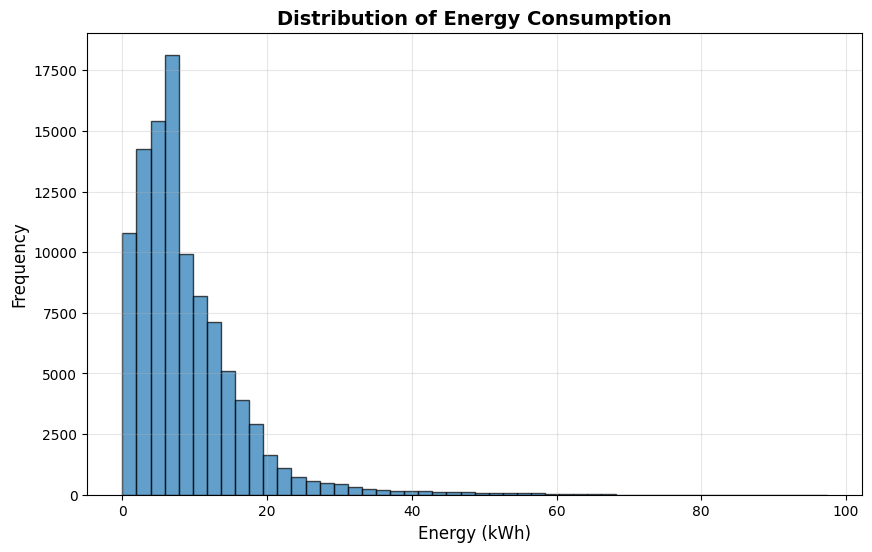

In [19]:
# Check the target variable (Energy kWh)
print("Target Variable: Energy (kWh)")
print(f"Mean: {df['Energy (kWh)'].mean():.2f} kWh")
print(f"Min: {df['Energy (kWh)'].min():.2f} kWh")
print(f"Max: {df['Energy (kWh)'].max():.2f} kWh")
print(f"Std: {df['Energy (kWh)'].std():.2f} kWh")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Energy (kWh)'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Energy (kWh)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Energy Consumption', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()


## Step 3: Feature Selection - Keep Only Important Features

Based on correlation analysis, we'll keep the most important features for prediction.


In [20]:
# Select important features based on correlation analysis
# We'll keep features that are highly correlated with Energy (kWh) and remove redundant ones

features_to_keep = [
    # Target variable
    'Energy (kWh)',
    
    # Core features (high correlation with Energy)
    'Charging Time (minutes)',
    'Total Duration (minutes)',
    'Fee',
    
    # Port and Station features
    'Port Type Encoded',
    'Port Number',
    'EVSE ID',
    
    # Time features
    'hour',
    'day_of_week',
    'month',
    'year',
    'is_weekend',
    'is_peak_hour',
    'season_encoded',
    'time_of_day_encoded',
    
    # Location features
    'Latitude',
    'Longitude',
    'County Encoded',
    
    # User behavior features
    'User ID',
    'User Avg Energy',
    'User Avg Fee',
    'User Avg Charging Time',
    'User Std Energy',
    'User Frequency',
    
    # Station features
    'Station Avg Energy',
    'Station Avg Fee',
    'Station Avg Charging Time',
    'Station Popularity',
    'Station Unique Users',
    
    # Engineered features
    'Energy per Hour',
    'Fee per kWh',
    'Charging Efficiency',
    'Hourly Avg Energy'
]

# Filter dataset to keep only selected features
df_selected = df[features_to_keep].copy()

print(f"Original columns: {len(df.columns)}")
print(f"Selected columns: {len(df_selected.columns)}")
print(f"Removed: {len(df.columns) - len(df_selected.columns)} columns")
print(f"\nSelected features: {len(features_to_keep) - 1} (excluding target)")
df_selected.head()


Original columns: 71
Selected columns: 33
Removed: 38 columns

Selected features: 32 (excluding target)


,Energy (kWh),Charging Time (minutes),Total Duration (minutes),Fee,Port Type Encoded,Port Number,EVSE ID,hour,day_of_week,month,...,User Frequency,Station Avg Energy,Station Avg Fee,Station Avg Charging Time,Station Popularity,Station Unique Users,Energy per Hour,Fee per kWh,Charging Efficiency,Hourly Avg Energy
0,51.661,524.716667,525.366667,11.88,1,2,109701,10,0,1,...,98,7.309364,1.854472,99.423064,5020,1286,5.907302,0.229961,5.899993,8.021722
1,14.197,143.966667,207.966667,4.20,1,2,104339,12,0,1,...,120,9.125173,2.335307,109.135863,3729,1271,5.916784,0.295837,4.095944,8.383963
2,1.977,20.233333,20.550000,0.45,1,1,27313,9,0,1,...,58,8.448678,2.070243,104.588459,3450,1041,5.862586,0.227617,5.772246,8.768460
3,2.895,78.233333,78.666667,0.67,1,2,107427,10,0,1,...,331,6.856201,1.737825,105.022604,3517,913,2.220280,0.231433,2.208049,8.021722
4,15.706,151.883333,153.866667,3.61,1,1,189855,12,0,1,...,4,9.243470,2.471182,124.029315,4737,1526,6.204497,0.229848,6.124521,8.383963


In [21]:
# Check for missing values
missing = df_selected.isnull().sum()
print("Missing values:")
print(missing[missing > 0])

# Fill any missing values with median (if any)
if missing.sum() > 0:
    df_selected = df_selected.fillna(df_selected.median())
    print("\nMissing values filled with median")
else:
    print("\nNo missing values found!")


Missing values:
User Std Energy    6976
dtype: int64

Missing values filled with median


## Step 4: Prepare Data for Modeling

Separate features (X) and target (y), then split into train and test sets.


In [22]:
# Separate features (X) and target (y)
X = df_selected.drop('Energy (kWh)', axis=1)
y = df_selected['Energy (kWh)']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)
print(f"\nFeatures: {list(X.columns)}")


Features (X) shape: (102781, 32)
Target (y) shape: (102781,)

Features: ['Charging Time (minutes)', 'Total Duration (minutes)', 'Fee', 'Port Type Encoded', 'Port Number', 'EVSE ID', 'hour', 'day_of_week', 'month', 'year', 'is_weekend', 'is_peak_hour', 'season_encoded', 'time_of_day_encoded', 'Latitude', 'Longitude', 'County Encoded', 'User ID', 'User Avg Energy', 'User Avg Fee', 'User Avg Charging Time', 'User Std Energy', 'User Frequency', 'Station Avg Energy', 'Station Avg Fee', 'Station Avg Charging Time', 'Station Popularity', 'Station Unique Users', 'Energy per Hour', 'Fee per kWh', 'Charging Efficiency', 'Hourly Avg Energy']


In [23]:
# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")

print("\nTest set:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

print(f"\nTrain percentage: {len(X_train) / len(X) * 100:.1f}%")
print(f"Test percentage: {len(X_test) / len(X) * 100:.1f}%")


Train set:
  X_train: (82224, 32)
  y_train: (82224,)

Test set:
  X_test: (20557, 32)
  y_test: (20557,)

Train percentage: 80.0%
Test percentage: 20.0%


In [24]:
# Scale the features for better model performance
# We'll use StandardScaler for most models and MinMaxScaler for LSTM

# StandardScaler (for Linear Regression, Random Forest, XGBoost)
scaler_standard = StandardScaler()
X_train_scaled = scaler_standard.fit_transform(X_train)
X_test_scaled = scaler_standard.transform(X_test)

# Convert back to DataFrame to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# MinMaxScaler (for LSTM - needs values between 0 and 1)
scaler_minmax = MinMaxScaler()
X_train_scaled_lstm = scaler_minmax.fit_transform(X_train)
X_test_scaled_lstm = scaler_minmax.transform(X_test)

print("Feature scaling completed!")
print(f"StandardScaler - Train mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")
print(f"MinMaxScaler - Train min: {X_train_scaled_lstm.min():.4f}, max: {X_train_scaled_lstm.max():.4f}")


Feature scaling completed!
StandardScaler - Train mean: 0.0000, Std: 1.0000
MinMaxScaler - Train min: 0.0000, max: 1.0000


## Model 1: Linear Regression

Simple baseline model to understand linear relationships.


In [25]:
# Train Linear Regression model
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Calculate metrics
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print("\nLinear Regression Results:")
print(f"Train RMSE: {lr_train_rmse:.4f} kWh")
print(f"Test RMSE: {lr_test_rmse:.4f} kWh")
print(f"Train MAE: {lr_train_mae:.4f} kWh")
print(f"Test MAE: {lr_test_mae:.4f} kWh")
print(f"Train R²: {lr_train_r2:.4f}")
print(f"Test R²: {lr_test_r2:.4f}")


Training Linear Regression...

Linear Regression Results:
Train RMSE: 1.4282 kWh
Test RMSE: 1.7098 kWh
Train MAE: 0.9058 kWh
Test MAE: 0.9212 kWh
Train R²: 0.9648
Test R²: 0.9507


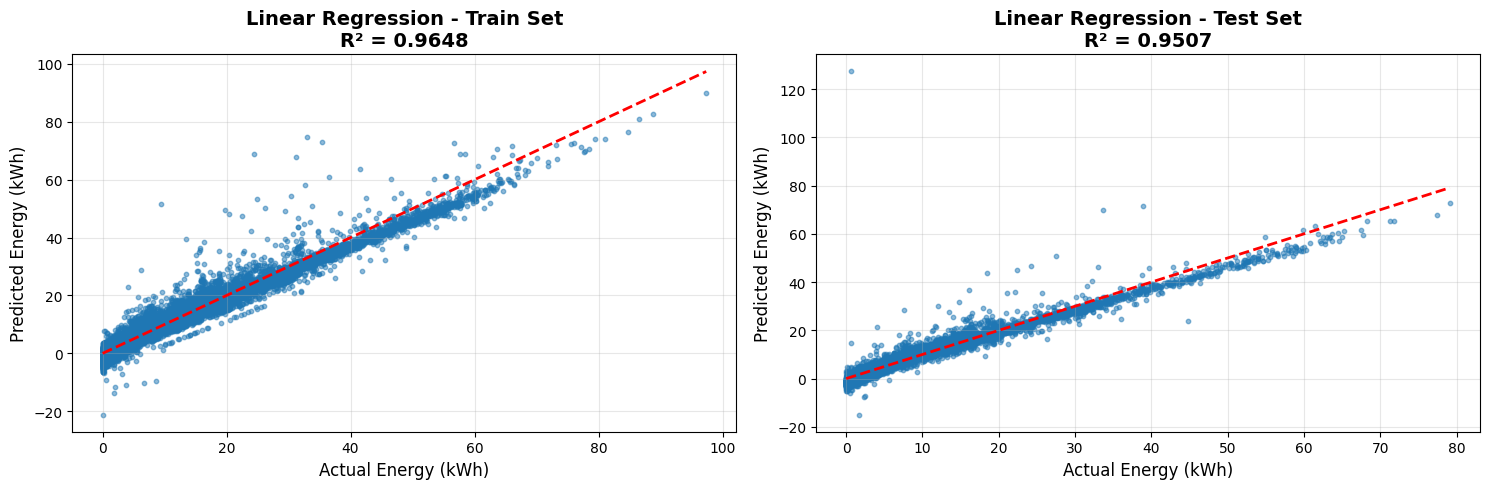

In [26]:
# Visualize Linear Regression predictions
plt.figure(figsize=(15, 5))

# Actual vs Predicted - Train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_lr, alpha=0.5, s=10)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Energy (kWh)', fontsize=12)
plt.ylabel('Predicted Energy (kWh)', fontsize=12)
plt.title(f'Linear Regression - Train Set\nR² = {lr_train_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Actual vs Predicted - Test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_lr, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Energy (kWh)', fontsize=12)
plt.ylabel('Predicted Energy (kWh)', fontsize=12)
plt.title(f'Linear Regression - Test Set\nR² = {lr_test_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Model 2: Random Forest

Ensemble model using multiple decision trees for better accuracy.


In [27]:
# Train Random Forest model
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=20,          # Maximum depth of trees
    min_samples_split=5,   # Minimum samples to split
    min_samples_leaf=2,   # Minimum samples in leaf
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Calculate metrics
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

print("\nRandom Forest Results:")
print(f"Train RMSE: {rf_train_rmse:.4f} kWh")
print(f"Test RMSE: {rf_test_rmse:.4f} kWh")
print(f"Train MAE: {rf_train_mae:.4f} kWh")
print(f"Test MAE: {rf_test_mae:.4f} kWh")
print(f"Train R²: {rf_train_r2:.4f}")
print(f"Test R²: {rf_test_r2:.4f}")


Training Random Forest...

Random Forest Results:
Train RMSE: 0.1517 kWh
Test RMSE: 0.2903 kWh
Train MAE: 0.0119 kWh
Test MAE: 0.0251 kWh
Train R²: 0.9996
Test R²: 0.9986


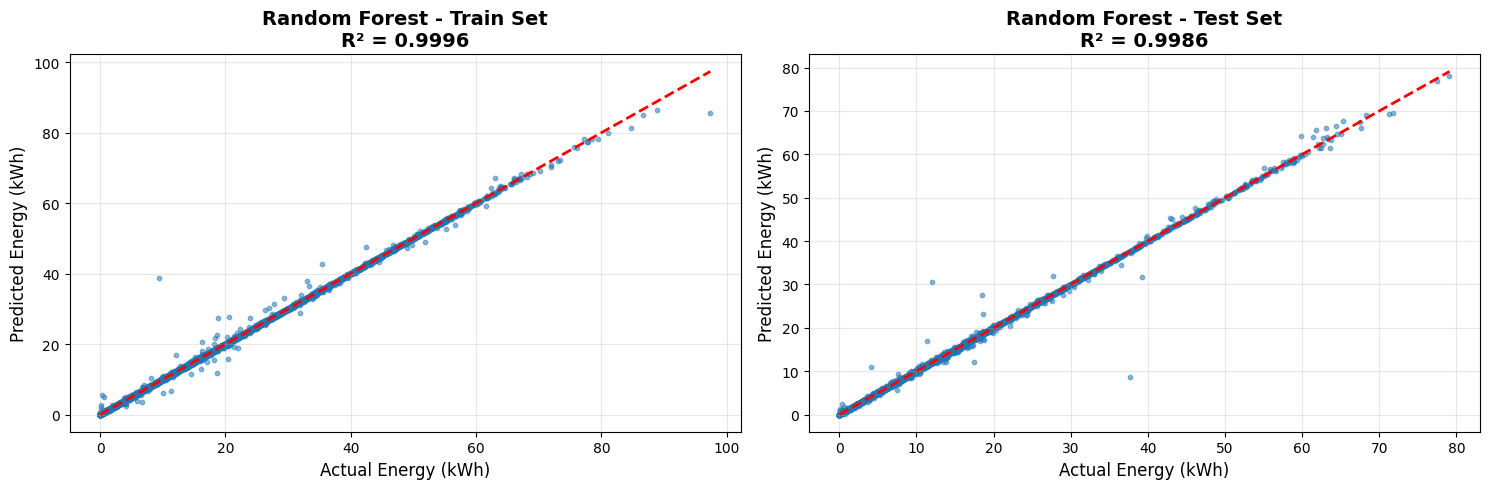


Top 10 Most Important Features:
                     Feature  Importance
2                        Fee    0.683133
0    Charging Time (minutes)    0.266435
30       Charging Efficiency    0.019552
28           Energy per Hour    0.018568
29               Fee per kWh    0.011776
1   Total Duration (minutes)    0.000207
18           User Avg Energy    0.000051
21           User Std Energy    0.000048
19              User Avg Fee    0.000040
22            User Frequency    0.000026


In [28]:
# Visualize Random Forest predictions
plt.figure(figsize=(15, 5))

# Actual vs Predicted - Train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf, alpha=0.5, s=10)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Energy (kWh)', fontsize=12)
plt.ylabel('Predicted Energy (kWh)', fontsize=12)
plt.title(f'Random Forest - Train Set\nR² = {rf_train_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Actual vs Predicted - Test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Energy (kWh)', fontsize=12)
plt.ylabel('Predicted Energy (kWh)', fontsize=12)
plt.title(f'Random Forest - Test Set\nR² = {rf_test_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


## Model 3: XGBoost

Advanced gradient boosting model known for high accuracy.


In [29]:
# Train XGBoost model
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=200,       # Number of boosting rounds
    max_depth=10,           # Maximum tree depth
    learning_rate=0.1,      # Learning rate
    subsample=0.8,          # Fraction of samples for training
    colsample_bytree=0.8,   # Fraction of features for training
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculate metrics
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
xgb_train_mae = mean_absolute_error(y_train, y_train_pred_xgb)
xgb_test_mae = mean_absolute_error(y_test, y_test_pred_xgb)
xgb_train_r2 = r2_score(y_train, y_train_pred_xgb)
xgb_test_r2 = r2_score(y_test, y_test_pred_xgb)

print("\nXGBoost Results:")
print(f"Train RMSE: {xgb_train_rmse:.4f} kWh")
print(f"Test RMSE: {xgb_test_rmse:.4f} kWh")
print(f"Train MAE: {xgb_train_mae:.4f} kWh")
print(f"Test MAE: {xgb_test_mae:.4f} kWh")
print(f"Train R²: {xgb_train_r2:.4f}")
print(f"Test R²: {xgb_test_r2:.4f}")


Training XGBoost...

XGBoost Results:
Train RMSE: 0.0288 kWh
Test RMSE: 0.2854 kWh
Train MAE: 0.0204 kWh
Test MAE: 0.0605 kWh
Train R²: 1.0000
Test R²: 0.9986


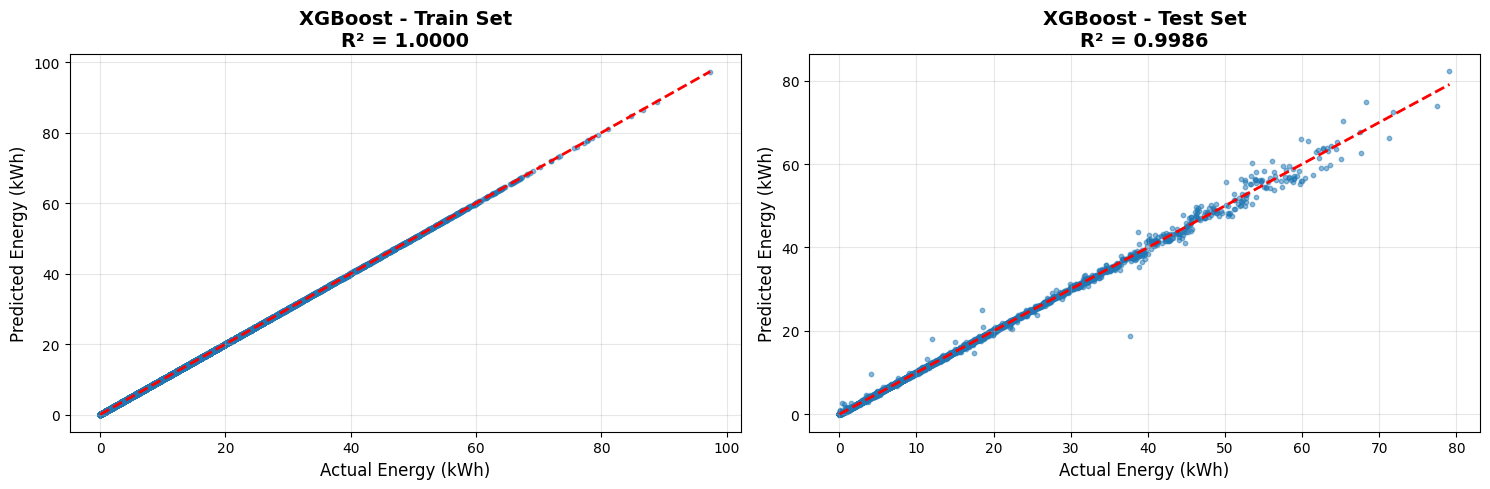


Top 10 Most Important Features:
                     Feature  Importance
2                        Fee    0.498724
0    Charging Time (minutes)    0.229555
1   Total Duration (minutes)    0.129010
28           Energy per Hour    0.065045
30       Charging Efficiency    0.056340
29               Fee per kWh    0.010238
20    User Avg Charging Time    0.004116
18           User Avg Energy    0.001764
3          Port Type Encoded    0.000772
21           User Std Energy    0.000614


In [30]:
# Visualize XGBoost predictions
plt.figure(figsize=(15, 5))

# Actual vs Predicted - Train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_xgb, alpha=0.5, s=10)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Energy (kWh)', fontsize=12)
plt.ylabel('Predicted Energy (kWh)', fontsize=12)
plt.title(f'XGBoost - Train Set\nR² = {xgb_train_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Actual vs Predicted - Test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_xgb, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Energy (kWh)', fontsize=12)
plt.ylabel('Predicted Energy (kWh)', fontsize=12)
plt.title(f'XGBoost - Test Set\nR² = {xgb_test_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(xgb_feature_importance.head(10))


## Model 4: LSTM (Long Short-Term Memory)

Deep learning model for sequential/time series patterns. We'll reshape the data for LSTM.


In [31]:
# Prepare data for LSTM
# LSTM needs data in 3D format: (samples, timesteps, features)
# We'll use a sequence length of 1 (each sample is independent)

# Reshape data for LSTM (samples, timesteps=1, features)
# Note: X_train_scaled_lstm is already a numpy array from MinMaxScaler, so we don't need .values
X_train_lstm = X_train_scaled_lstm.reshape((X_train_scaled_lstm.shape[0], 1, X_train_scaled_lstm.shape[1]))
X_test_lstm = X_test_scaled_lstm.reshape((X_test_scaled_lstm.shape[0], 1, X_test_scaled_lstm.shape[1]))

print("LSTM Data Shape:")
print(f"X_train_lstm: {X_train_lstm.shape}")
print(f"X_test_lstm: {X_test_lstm.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


LSTM Data Shape:
X_train_lstm: (82224, 1, 32)
X_test_lstm: (20557, 1, 32)
y_train: (82224,)
y_test: (20557,)


In [32]:
# Build LSTM model
print("Building LSTM model...")

lstm_model = Sequential([
    # First LSTM layer with 128 units
    LSTM(128, activation='relu', return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),  # Prevent overfitting
    
    # Second LSTM layer with 64 units
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    
    # Dense layers
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    
    # Output layer (single value - Energy prediction)
    Dense(1)
])

# Compile the model
lstm_model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error
)

print("\nLSTM Model Architecture:")
lstm_model.summary()


Building LSTM model...

LSTM Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            82432     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_

In [33]:
# Train LSTM model
print("Training LSTM model...")
print("This may take a few minutes...")

# Train the model
history = lstm_model.fit(
    X_train_lstm, y_train,
    batch_size=64,           # Process 64 samples at a time
    epochs=50,               # Number of training iterations
    validation_data=(X_test_lstm, y_test),
    verbose=1,               # Show training progress
    shuffle=True             # Shuffle training data
)

print("\nLSTM training completed!")


Training LSTM model...
This may take a few minutes...
Epoch 1/50
1285/1285 [==============================] - 17s 10ms/step - loss: 16.4596 - mae: 2.4625 - val_loss: 3.2442 - val_mae: 0.9681
Epoch 2/50
1285/1285 [==============================] - 13s 10ms/step - loss: 4.0073 - mae: 1.2914 - val_loss: 2.5794 - val_mae: 0.5769
Epoch 3/50
1285/1285 [==============================] - 12s 10ms/step - loss: 2.7401 - mae: 1.0549 - val_loss: 2.7767 - val_mae: 0.6073
Epoch 4/50
1285/1285 [==============================] - 13s 10ms/step - loss: 2.3008 - mae: 0.9572 - val_loss: 2.9737 - val_mae: 0.5153
Epoch 5/50
1285/1285 [==============================] - 13s 10ms/step - loss: 2.0128 - mae: 0.8941 - val_loss: 3.2383 - val_mae: 0.4381
Epoch 6/50
1285/1285 [==============================] - 13s 10ms/step - loss: 1.8978 - mae: 0.8526 - val_loss: 3.7159 - val_mae: 0.7876
Epoch 7/50
1285/1285 [==============================] - 13s 10ms/step - loss: 1.6824 - mae: 0.8053 - val_loss: 3.3683 - val_mae: 

In [34]:
# Make predictions with LSTM
y_train_pred_lstm = lstm_model.predict(X_train_lstm).flatten()
y_test_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Calculate metrics
lstm_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lstm))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lstm))
lstm_train_mae = mean_absolute_error(y_train, y_train_pred_lstm)
lstm_test_mae = mean_absolute_error(y_test, y_test_pred_lstm)
lstm_train_r2 = r2_score(y_train, y_train_pred_lstm)
lstm_test_r2 = r2_score(y_test, y_test_pred_lstm)

print("\nLSTM Results:")
print(f"Train RMSE: {lstm_train_rmse:.4f} kWh")
print(f"Test RMSE: {lstm_test_rmse:.4f} kWh")
print(f"Train MAE: {lstm_train_mae:.4f} kWh")
print(f"Test MAE: {lstm_test_mae:.4f} kWh")
print(f"Train R²: {lstm_train_r2:.4f}")
print(f"Test R²: {lstm_test_r2:.4f}")


643/643 [==============================] - 1s 2ms/step

LSTM Results:
Train RMSE: 0.9295 kWh
Test RMSE: 1.7803 kWh
Train MAE: 0.7017 kWh
Test MAE: 0.7191 kWh
Train R²: 0.9851
Test R²: 0.9465


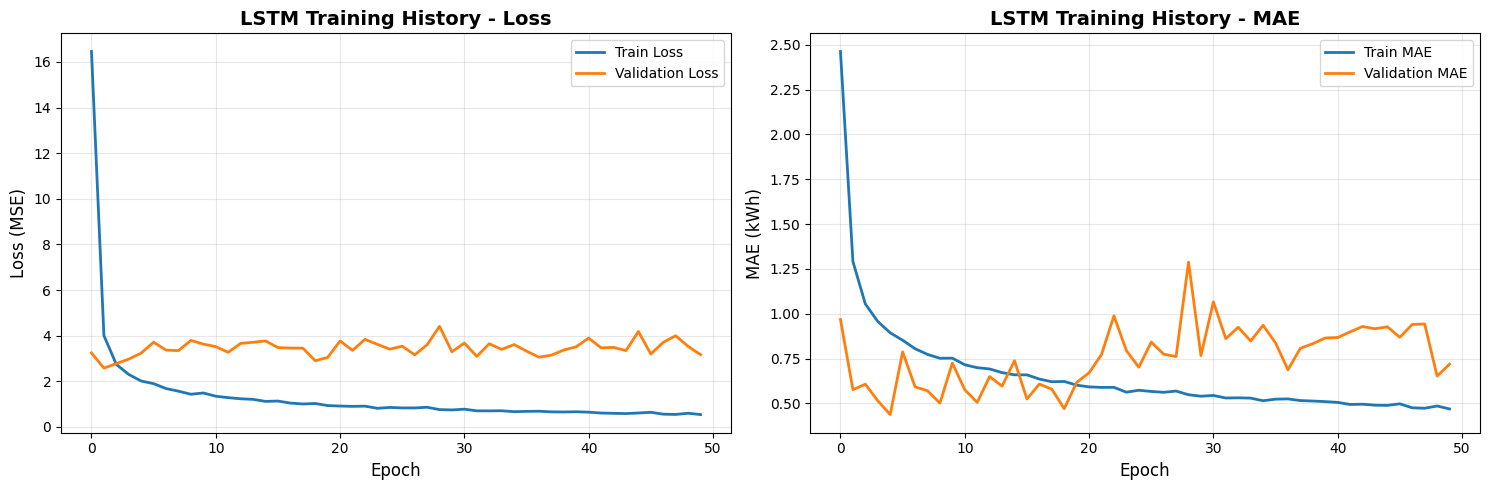

In [35]:
# Visualize LSTM training history
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('LSTM Training History - Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE (kWh)', fontsize=12)
plt.title('LSTM Training History - MAE', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


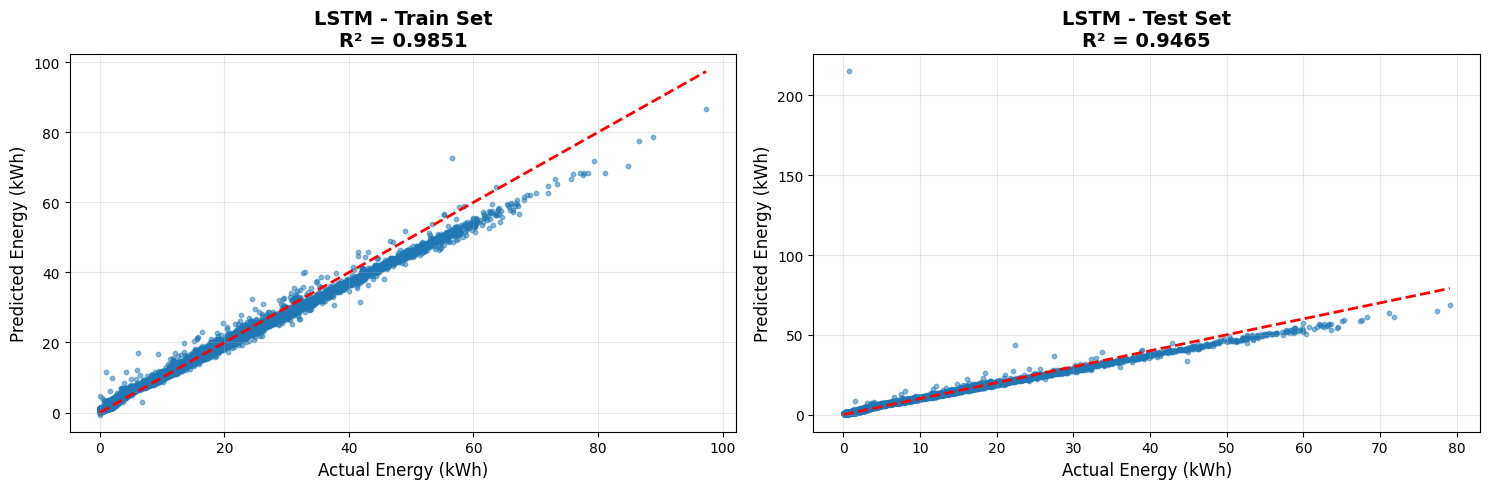

In [36]:
# Visualize LSTM predictions
plt.figure(figsize=(15, 5))

# Actual vs Predicted - Train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_lstm, alpha=0.5, s=10)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Energy (kWh)', fontsize=12)
plt.ylabel('Predicted Energy (kWh)', fontsize=12)
plt.title(f'LSTM - Train Set\nR² = {lstm_train_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Actual vs Predicted - Test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_lstm, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Energy (kWh)', fontsize=12)
plt.ylabel('Predicted Energy (kWh)', fontsize=12)
plt.title(f'LSTM - Test Set\nR² = {lstm_test_r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Step 5: Model Comparison

Compare all 4 models to see which performs best.


In [37]:
# Create comparison table
comparison_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LSTM'],
    'Train RMSE': [lr_train_rmse, rf_train_rmse, xgb_train_rmse, lstm_train_rmse],
    'Test RMSE': [lr_test_rmse, rf_test_rmse, xgb_test_rmse, lstm_test_rmse],
    'Train MAE': [lr_train_mae, rf_train_mae, xgb_train_mae, lstm_train_mae],
    'Test MAE': [lr_test_mae, rf_test_mae, xgb_test_mae, lstm_test_mae],
    'Train R²': [lr_train_r2, rf_train_r2, xgb_train_r2, lstm_train_r2],
    'Test R²': [lr_test_r2, rf_test_r2, xgb_test_r2, lstm_test_r2]
})

# Round to 4 decimal places
comparison_results = comparison_results.round(4)

print("=" * 80)
print("MODEL COMPARISON - ALL METRICS")
print("=" * 80)
print(comparison_results.to_string(index=False))

# Find best model for each metric
print("\n" + "=" * 80)
print("BEST MODEL FOR EACH METRIC")
print("=" * 80)
print(f"Best Test RMSE: {comparison_results.loc[comparison_results['Test RMSE'].idxmin(), 'Model']} ({comparison_results['Test RMSE'].min():.4f} kWh)")
print(f"Best Test MAE: {comparison_results.loc[comparison_results['Test MAE'].idxmin(), 'Model']} ({comparison_results['Test MAE'].min():.4f} kWh)")
print(f"Best Test R²: {comparison_results.loc[comparison_results['Test R²'].idxmax(), 'Model']} ({comparison_results['Test R²'].max():.4f})")


MODEL COMPARISON - ALL METRICS
            Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²
Linear Regression      1.4282     1.7098     0.9058    0.9212    0.9648   0.9507
    Random Forest      0.1517     0.2903     0.0119    0.0251    0.9996   0.9986
          XGBoost      0.0288     0.2854     0.0204    0.0605    1.0000   0.9986
             LSTM      0.9295     1.7803     0.7017    0.7191    0.9851   0.9465

BEST MODEL FOR EACH METRIC
Best Test RMSE: XGBoost (0.2854 kWh)
Best Test MAE: Random Forest (0.0251 kWh)
Best Test R²: Random Forest (0.9986)


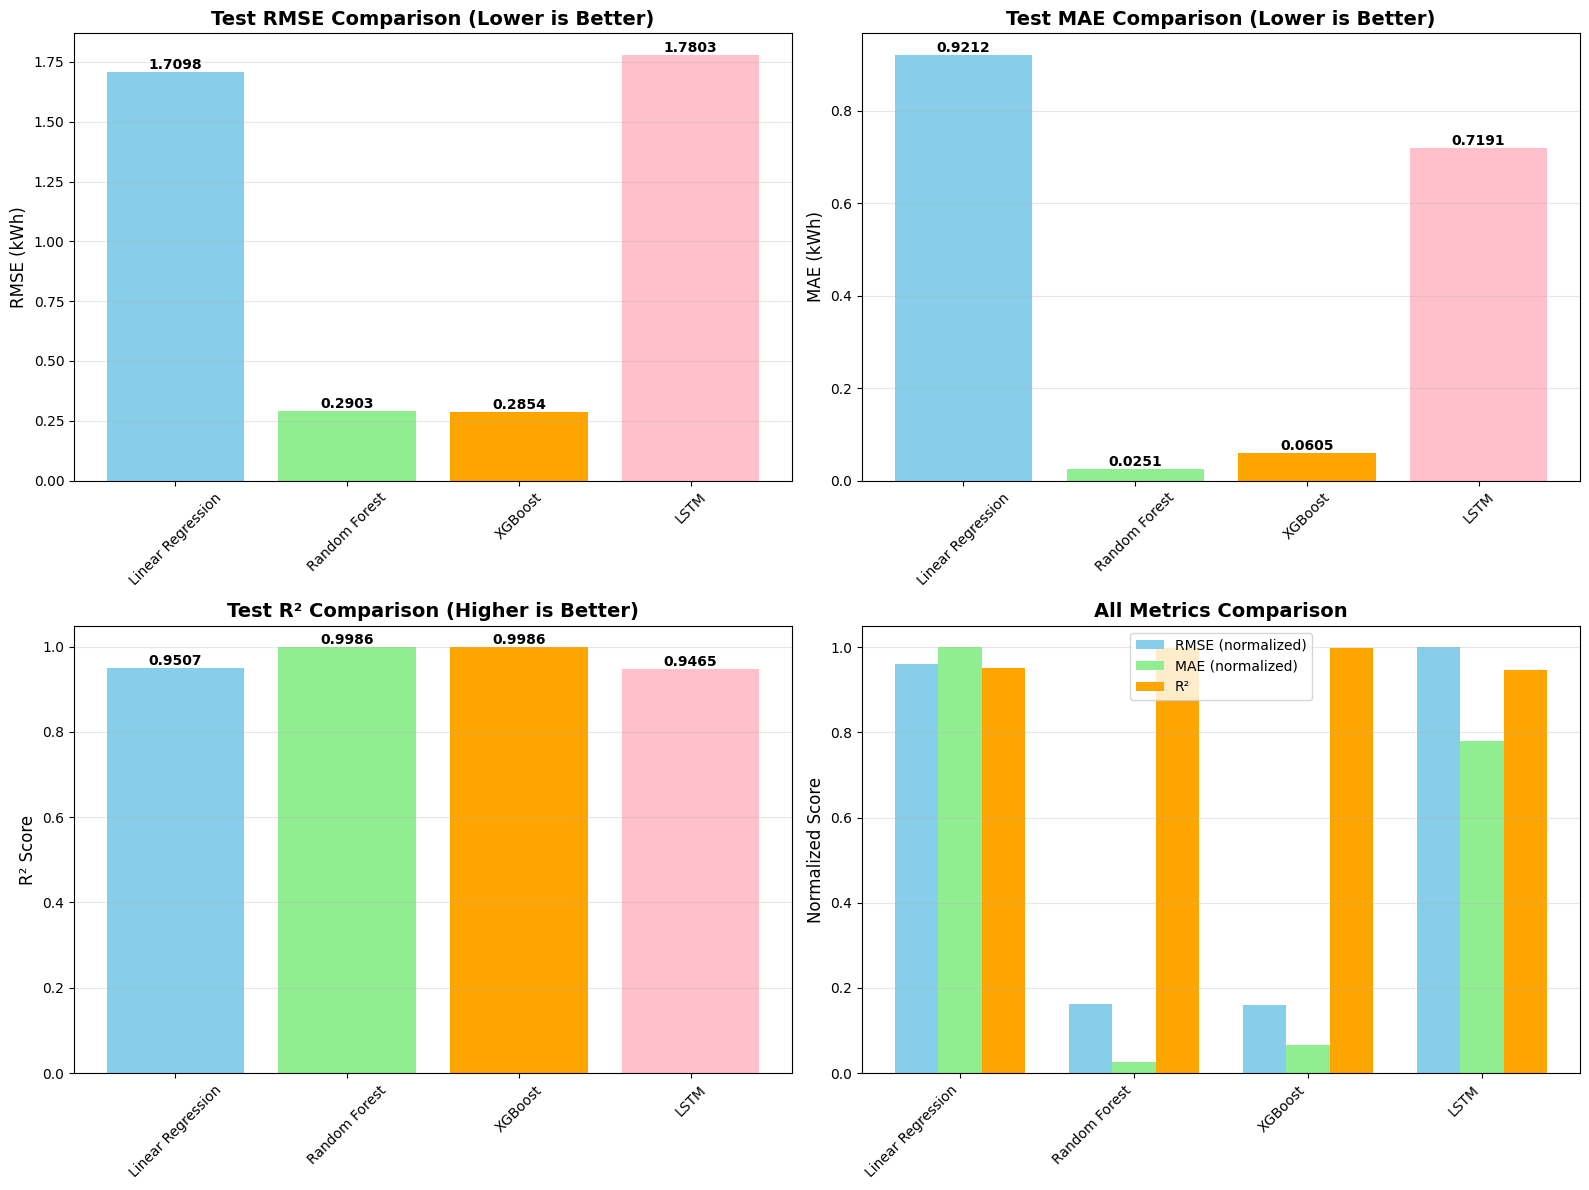

In [38]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test RMSE comparison
axes[0, 0].bar(comparison_results['Model'], comparison_results['Test RMSE'], color=['skyblue', 'lightgreen', 'orange', 'pink'])
axes[0, 0].set_ylabel('RMSE (kWh)', fontsize=12)
axes[0, 0].set_title('Test RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_results['Test RMSE']):
    axes[0, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Test MAE comparison
axes[0, 1].bar(comparison_results['Model'], comparison_results['Test MAE'], color=['skyblue', 'lightgreen', 'orange', 'pink'])
axes[0, 1].set_ylabel('MAE (kWh)', fontsize=12)
axes[0, 1].set_title('Test MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_results['Test MAE']):
    axes[0, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Test R² comparison
axes[1, 0].bar(comparison_results['Model'], comparison_results['Test R²'], color=['skyblue', 'lightgreen', 'orange', 'pink'])
axes[1, 0].set_ylabel('R² Score', fontsize=12)
axes[1, 0].set_title('Test R² Comparison (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_results['Test R²']):
    axes[1, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# All metrics comparison
x = np.arange(len(comparison_results['Model']))
width = 0.25
axes[1, 1].bar(x - width, comparison_results['Test RMSE'] / comparison_results['Test RMSE'].max(), width, label='RMSE (normalized)', color='skyblue')
axes[1, 1].bar(x, comparison_results['Test MAE'] / comparison_results['Test MAE'].max(), width, label='MAE (normalized)', color='lightgreen')
axes[1, 1].bar(x + width, comparison_results['Test R²'], width, label='R²', color='orange')
axes[1, 1].set_ylabel('Normalized Score', fontsize=12)
axes[1, 1].set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_results['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


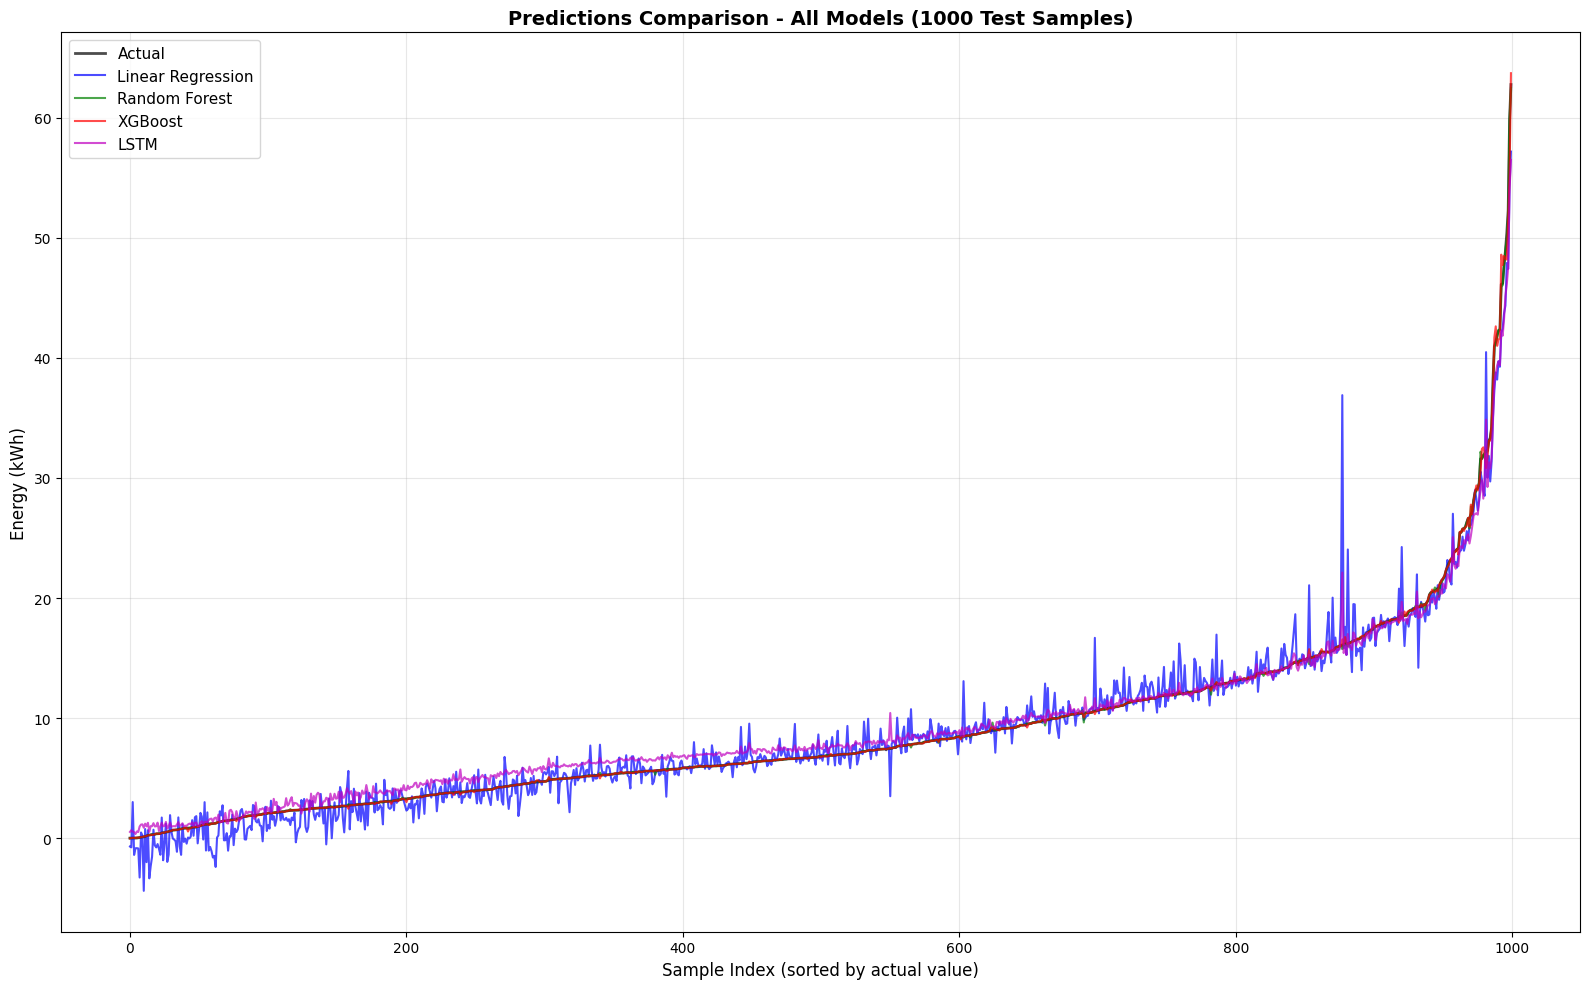

In [39]:
# Compare predictions from all models on test set
# Sample 1000 random test samples for visualization
sample_indices = np.random.choice(len(y_test), 1000, replace=False)
y_test_sample = y_test.iloc[sample_indices].values
y_pred_lr_sample = y_test_pred_lr[sample_indices]
y_pred_rf_sample = y_test_pred_rf[sample_indices]
y_pred_xgb_sample = y_test_pred_xgb[sample_indices]
y_pred_lstm_sample = y_test_pred_lstm[sample_indices]

# Sort by actual values for better visualization
sort_idx = np.argsort(y_test_sample)
y_test_sorted = y_test_sample[sort_idx]
y_pred_lr_sorted = y_pred_lr_sample[sort_idx]
y_pred_rf_sorted = y_pred_rf_sample[sort_idx]
y_pred_xgb_sorted = y_pred_xgb_sample[sort_idx]
y_pred_lstm_sorted = y_pred_lstm_sample[sort_idx]

# Plot predictions comparison
plt.figure(figsize=(16, 10))

x_axis = np.arange(len(y_test_sorted))

plt.plot(x_axis, y_test_sorted, 'k-', label='Actual', linewidth=2, alpha=0.7)
plt.plot(x_axis, y_pred_lr_sorted, 'b-', label='Linear Regression', linewidth=1.5, alpha=0.7)
plt.plot(x_axis, y_pred_rf_sorted, 'g-', label='Random Forest', linewidth=1.5, alpha=0.7)
plt.plot(x_axis, y_pred_xgb_sorted, 'r-', label='XGBoost', linewidth=1.5, alpha=0.7)
plt.plot(x_axis, y_pred_lstm_sorted, 'm-', label='LSTM', linewidth=1.5, alpha=0.7)

plt.xlabel('Sample Index (sorted by actual value)', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.title('Predictions Comparison - All Models (1000 Test Samples)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Step 6: Final Summary

Summary of all models and their performance.


In [40]:
print("=" * 80)
print("FINAL SUMMARY - MODEL PERFORMANCE")
print("=" * 80)
print("\n1. LINEAR REGRESSION:")
print(f"   - Test RMSE: {lr_test_rmse:.4f} kWh")
print(f"   - Test MAE: {lr_test_mae:.4f} kWh")
print(f"   - Test R²: {lr_test_r2:.4f}")
print(f"   - Accuracy: {lr_test_r2*100:.2f}%")

print("\n2. RANDOM FOREST:")
print(f"   - Test RMSE: {rf_test_rmse:.4f} kWh")
print(f"   - Test MAE: {rf_test_mae:.4f} kWh")
print(f"   - Test R²: {rf_test_r2:.4f}")
print(f"   - Accuracy: {rf_test_r2*100:.2f}%")

print("\n3. XGBOOST:")
print(f"   - Test RMSE: {xgb_test_rmse:.4f} kWh")
print(f"   - Test MAE: {xgb_test_mae:.4f} kWh")
print(f"   - Test R²: {xgb_test_r2:.4f}")
print(f"   - Accuracy: {xgb_test_r2*100:.2f}%")

print("\n4. LSTM:")
print(f"   - Test RMSE: {lstm_test_rmse:.4f} kWh")
print(f"   - Test MAE: {lstm_test_mae:.4f} kWh")
print(f"   - Test R²: {lstm_test_r2:.4f}")
print(f"   - Accuracy: {lstm_test_r2*100:.2f}%")

print("\n" + "=" * 80)
print("BEST MODEL:")
print("=" * 80)
best_model_idx = comparison_results['Test R²'].idxmax()
best_model_name = comparison_results.loc[best_model_idx, 'Model']
best_r2 = comparison_results.loc[best_model_idx, 'Test R²']
best_rmse = comparison_results.loc[best_model_idx, 'Test RMSE']
best_mae = comparison_results.loc[best_model_idx, 'Test MAE']

print(f"\n🏆 WINNER: {best_model_name}")
print(f"   - Test R²: {best_r2:.4f} ({best_r2*100:.2f}% accuracy)")
print(f"   - Test RMSE: {best_rmse:.4f} kWh")
print(f"   - Test MAE: {best_mae:.4f} kWh")
print("\nThis model explains {:.2f}% of the variance in Energy consumption!".format(best_r2*100))


FINAL SUMMARY - MODEL PERFORMANCE

1. LINEAR REGRESSION:
   - Test RMSE: 1.7098 kWh
   - Test MAE: 0.9212 kWh
   - Test R²: 0.9507
   - Accuracy: 95.07%

2. RANDOM FOREST:
   - Test RMSE: 0.2903 kWh
   - Test MAE: 0.0251 kWh
   - Test R²: 0.9986
   - Accuracy: 99.86%

3. XGBOOST:
   - Test RMSE: 0.2854 kWh
   - Test MAE: 0.0605 kWh
   - Test R²: 0.9986
   - Accuracy: 99.86%

4. LSTM:
   - Test RMSE: 1.7803 kWh
   - Test MAE: 0.7191 kWh
   - Test R²: 0.9465
   - Accuracy: 94.65%

BEST MODEL:

🏆 WINNER: Random Forest
   - Test R²: 0.9986 (99.86% accuracy)
   - Test RMSE: 0.2903 kWh
   - Test MAE: 0.0251 kWh

This model explains 99.86% of the variance in Energy consumption!
